## Import saved random scrambled movie time series data

In [1]:
import numpy as np
import pandas as pd
df =  pd.read_csv("./new_movie_information_all_daily.csv")
df_data = pd.DataFrame()
df_data["Movie_Id"] = df["Movie_Id"]
for i in range(7):
    day_num = i + 1
    day_g_d = "D" + str(day_num) + "_GrossToDate"
    df_data[day_g_d] = df[day_g_d]
df_data["W1_Later_GrossToDate"] = df["W1_Later_GrossToDate"] /10000

In [7]:
df_data = df_data[df_data["W1_Later_GrossToDate"] != 0]
df_data.reset_index(drop = True)# 索引index,去掉索引
df_data.head(5)

,Movie_Id,D1_GrossToDate,D2_GrossToDate,D3_GrossToDate,D4_GrossToDate,D5_GrossToDate,D6_GrossToDate,D7_GrossToDate,W1_Later_GrossToDate
0,1,28.1455,49.5611,85.9173,140.4542,170.8668,177.0424,183.6513,229.2408
1,1,49.5611,85.9173,140.4542,170.8668,177.0424,183.6513,187.7916,230.6832
2,1,85.9173,140.4542,170.8668,177.0424,183.6513,187.7916,191.1079,231.3043
9,2,10.8337,24.5570,34.4661,36.5802,40.0935,42.5454,44.0710,59.9741
10,2,24.5570,34.4661,36.5802,40.0935,42.5454,44.0710,47.5398,60.8443


#### 重构数据，x是时间序列长度、y是样本数量（电影数），z是特征数

In [8]:
id = np.unique(df_data["Movie_Id"].values)##去重,排序
data_all = []
for n in range(21):
    all = []
    for m in range(len(id)):
        if((df_data[df_data["Movie_Id"] == id[m]].shape[0]) >= 21 ):
            a = df_data[df_data["Movie_Id"] == id[m]]
            a = a.values.tolist()[n]
            all.append(a)
    data_all.append(all)
data_all = np.array(data_all)
data_all.shape

(21, 3106, 9)

In [9]:
np.random.seed(844) 
permutation = list(np.random.permutation(data_all.shape[1]))#生成一列随机数

## test and train，test_size = 0.2   train_size = 0.8

In [12]:
train_y = []
train_x = []
test_y = []
test_x = []
size = int((data_all.shape[1]-1)*0.8)
for a in range(data_all.shape[0]):
    b = data_all[a][permutation]
    x_train = b[:size,1:-1]
    y_train = b[:size,-1]
    x_test = b[size:,1:-1]
    y_test = b[size:,-1]
    train_x.append(x_train)
    train_y.append(y_train)
    test_x.append(x_test)
    test_y.append(y_test)
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)

In [13]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(21, 2484, 7)
(21, 622, 7)
(21, 2484)
(21, 622)


## Normailzed

# X

In [15]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
shape_train = train_x.shape
shape_test = test_x.shape

In [16]:
train_x = s.fit_transform(train_x.reshape(-1,7))
test_x = s.transform(test_x.reshape(-1,7))

In [18]:
train_x = train_x.reshape(-1,shape_train[1],7)
test_x = test_x.reshape(-1,shape_test[1],7)
print("train_x:{},train_y:{},test_x:{},test_y:{}".format(train_x.shape,train_y.shape,test_x.shape,test_y.shape))

train_x:(21, 2484, 7),train_y:(21, 2484),test_x:(21, 622, 7),test_y:(21, 622)


## save result

In [19]:
pred_test = []
mae_all = []
medae_all = []
r2_all = []
Adjusted_R2_all = []
rmse_all = []

# Ensemble
## Prepare to enter data

In [23]:
x_train = train_x.reshape(-1,7).astype("float32")
x_test = test_x.reshape(-1,7).astype("float32")
y_train = train_y.reshape(-1,1).astype("float32")
y_test = test_y.reshape(-1,1).astype("float32")

In [24]:
print("x_train:{} {},y_train:{} {}\nx_test:{} {},y_test:{} {}".format(x_train.shape,x_train.dtype,y_train.shape,y_train.dtype,x_test.shape,x_test.dtype,y_test.shape,y_test.dtype))

x_train:(52164, 7) float32,y_train:(52164, 1) float32
x_test:(13062, 7) float32,y_test:(13062, 1) float32


## Gradient Boosting Regressor

In [29]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,median_absolute_error,r2_score
gbrg = GradientBoostingRegressor(n_estimators=1000,learning_rate=0.5,loss="huber",alpha=0.8)
gbrg.fit(x_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.8, criterion='friedman_mse', init=None,
             learning_rate=0.5, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [30]:
pred = gbrg.predict(x_test)
pred = pred.reshape(-1,1)
mae = mean_absolute_error(y_test,pred)
mse = mean_squared_error(y_test,pred)
medae = median_absolute_error(y_test,pred)
r2 = r2_score(y_test,pred)
Adjusted_R2 = 1-((1-r2_score(y_test,pred))*(len(pred)-1))/(len(pred)-7-1)
rmse = np.sqrt(mse)
print("mae:{},mse:{},medae:{},r2:{},adjusted_r2:{},rmse:{}".format(mae,mse,medae,r2,Adjusted_R2,rmse))
pred_test.append(pred)
mae_all.append(mae)
medae_all.append(medae)
r2_all.append(r2)
Adjusted_R2_all.append(Adjusted_R2)
rmse_all.append(rmse)

mae:164.35114050051084,mse:183269.03404393618,medae:53.79913227440579,r2:0.9955439441096425,adjusted_r2:0.9955415546205026,rmse:428.09932731077276


###  GBDT Plot

No handles with labels found to put in legend.


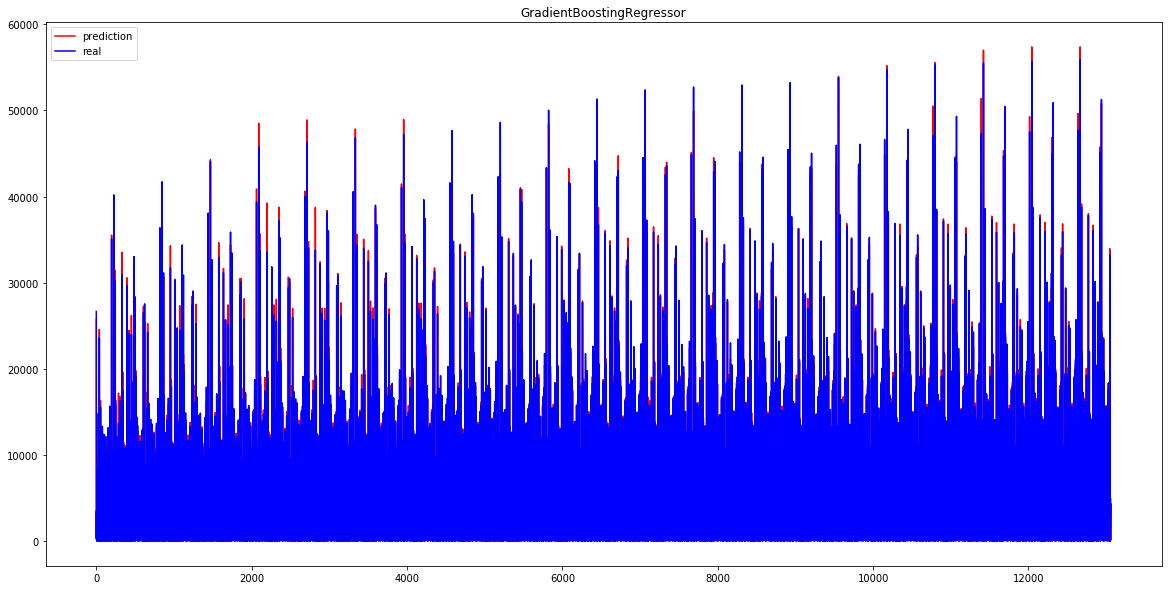

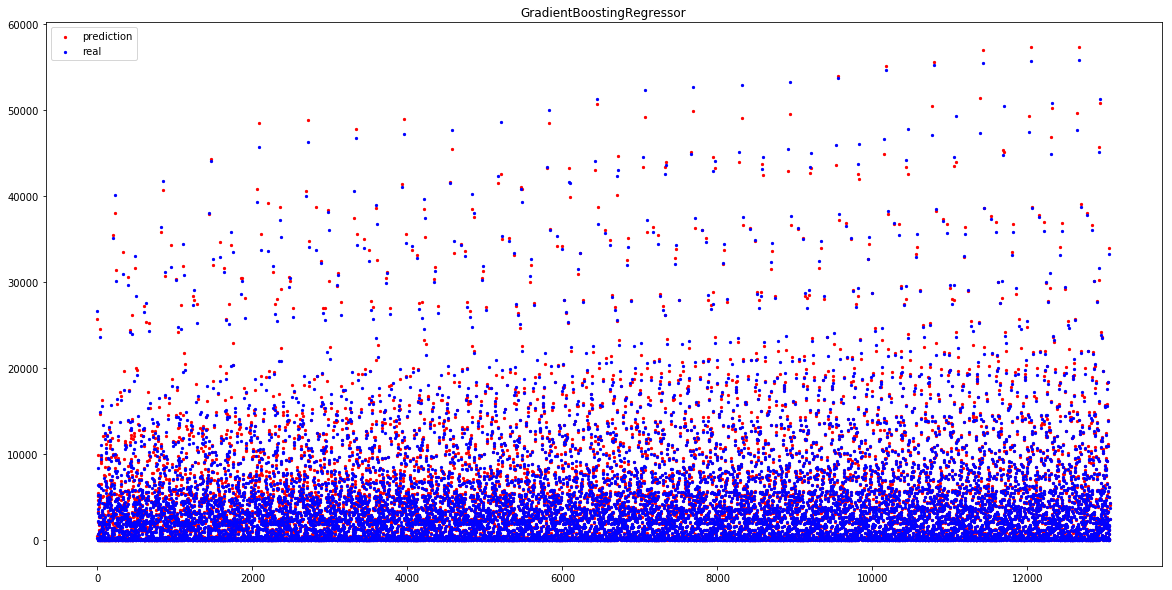

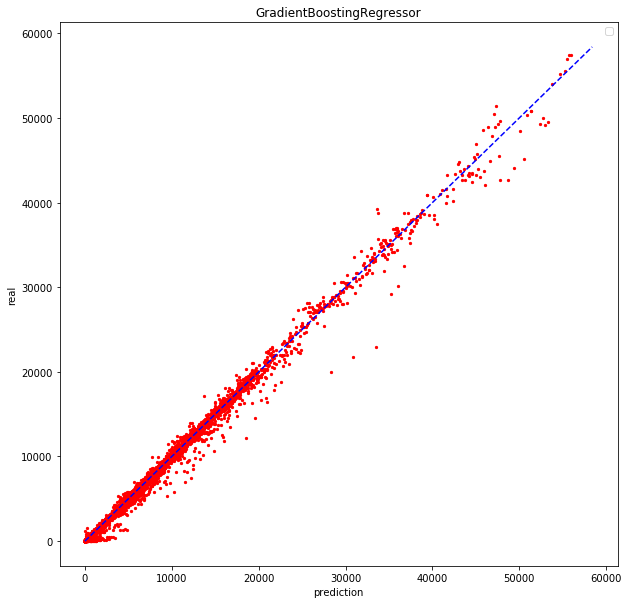

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(pred, 'r', label='prediction')
plt.plot(y_test, 'b', label='real')
plt.title("GradientBoostingRegressor")
plt.legend(loc='best')
plt.savefig("./figure/GBDT/plt_grb6.eps")
plt.figure(figsize=(20,10))
plt.scatter([i+1 for i in range(y_test.shape[0])],pred, color='r', label='prediction',s=5)
plt.scatter([i+1 for i in range(y_test.shape[0])],y_test, color='b', label='real',s=5)
plt.title("GradientBoostingRegressor")
plt.legend(loc='best')
plt.savefig("./figure/GBDT/scatter_grb6.eps")
plt.figure(figsize=(10,10))
plt.scatter(y_test,pred, color='r',s=5)
plt.plot([0,np.max([np.max(y_test),np.max(pred)])+1000],[0,np.max([np.max(y_test),np.max(pred)])+1000],"b",ls='--')
plt.title("GradientBoostingRegressor")
plt.ylabel("real")
plt.xlabel("prediction")
plt.legend(loc='best')
plt.savefig("./figure/GBDT/pt_grb6.eps")

## AdaBoostRegressor

In [36]:
from sklearn.ensemble import AdaBoostRegressor
adagr = AdaBoostRegressor(random_state=13,n_estimators=1000,learning_rate=0.5,loss="square")
adagr.fit(x_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=None, learning_rate=0.5, loss='square',
         n_estimators=1000, random_state=13)

In [37]:
pred = adagr.predict(x_test)
pred = pred.reshape(-1,1)
mae = mean_absolute_error(y_test,pred)
mse = mean_squared_error(y_test,pred)
medae = median_absolute_error(y_test,pred)
r2 = r2_score(y_test,pred)
Adjusted_R2 = 1-((1-r2_score(y_test,pred))*(len(pred)-1))/(len(pred)-7-1)
rmse = np.sqrt(mse)
print("mae:{},mse:{},medae:{},r2:{},adjusted_r2:{},rmse:{}".format(mae,mse,medae,r2,Adjusted_R2,rmse))
pred_test.append(pred)
mae_all.append(mae)
medae_all.append(medae)
r2_all.append(r2)
Adjusted_R2_all.append(Adjusted_R2)
rmse_all.append(rmse)

mae:5284.920066736371,mse:32719569.070052814,medae:5751.875722045546,r2:0.20444700739999477,adjusted_r2:0.2040204047534343,rmse:5720.102190525342


### AdaBoost plot

No handles with labels found to put in legend.


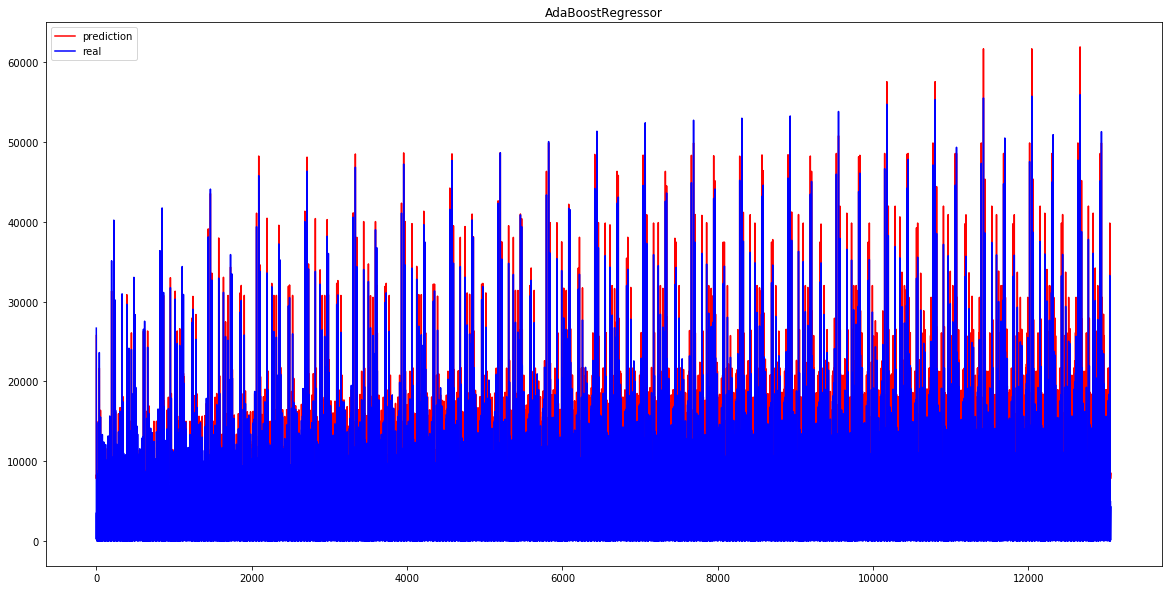

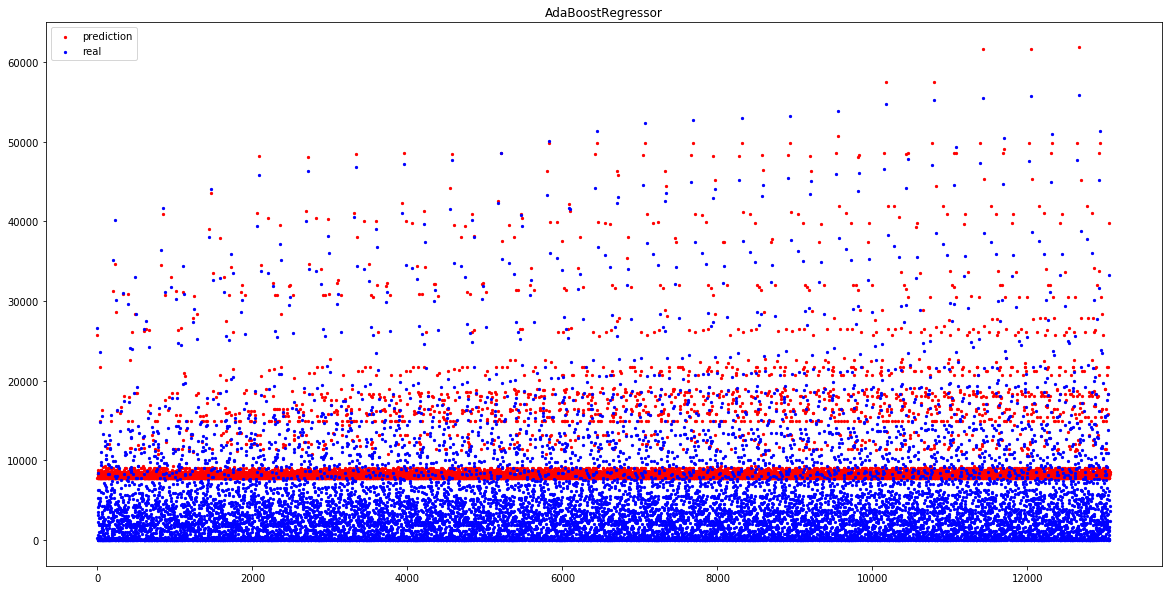

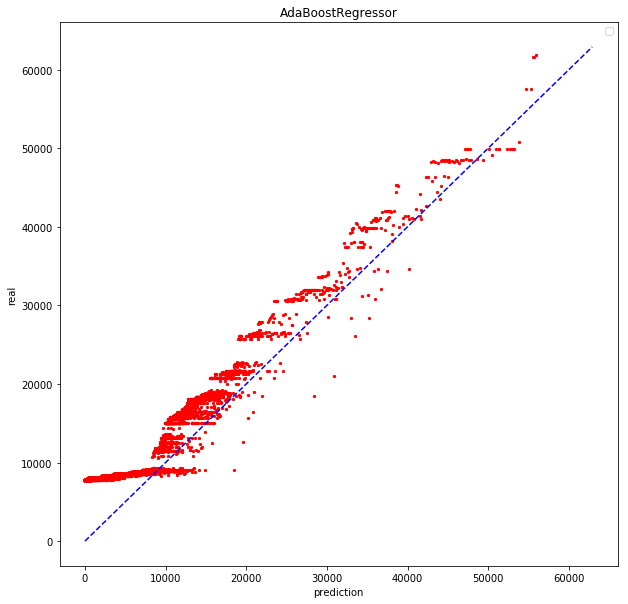

In [38]:
plt.figure(figsize=(20,10))
plt.plot(pred, 'r', label='prediction')
plt.plot(y_test, 'b', label='real')
plt.title("AdaBoostRegressor")
plt.legend(loc='best')
plt.savefig("./figure/AdaB/plt_ada4.eps")
plt.figure(figsize=(20,10))
plt.scatter([i+1 for i in range(y_test.shape[0])],pred, color='r', label='prediction',s=5)
plt.scatter([i+1 for i in range(y_test.shape[0])],y_test, color='b', label='real',s=5)
plt.title("AdaBoostRegressor")
plt.legend(loc='best')
plt.savefig("./figure/AdaB/scatter_ada4.eps")
plt.figure(figsize=(10,10))
plt.scatter(y_test,pred, color='r',s=5)
plt.plot([0,np.max([np.max(y_test),np.max(pred)])+1000],[0,np.max([np.max(y_test),np.max(pred)])+1000],"b",ls='--')
plt.title("AdaBoostRegressor")
plt.ylabel("real")
plt.xlabel("prediction")
plt.legend(loc='best')
plt.savefig("./figure/AdaB/pt_ada4.eps")

## RandomForestRegressor

In [39]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=450,oob_score=True)
rf.fit(x_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=450, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [42]:
pred = rf.predict(x_test)
pred = pred.reshape(-1,1)
mae = mean_absolute_error(y_test,pred)
mse = mean_squared_error(y_test,pred)
medae = median_absolute_error(y_test,pred)
r2 = r2_score(y_test,pred)
Adjusted_R2 = 1-((1-r2_score(y_test,pred))*(len(pred)-1))/(len(pred)-7-1)
rmse = np.sqrt(mse)
print("mae:{},mse:{},medae:{},r2:{},adjusted_r2:{},rmse:{}".format(mae,mse,medae,r2,Adjusted_R2,rmse))
pred_test.append(pred)
mae_all.append(mae)
medae_all.append(medae)
r2_all.append(r2)
Adjusted_R2_all.append(Adjusted_R2)
rmse_all.append(rmse)

mae:162.97506423159365,mse:178632.37189112863,medae:53.55622341579874,r2:0.9956566812439075,adjusted_r2:0.9956543522082638,rmse:422.6492303212306


No handles with labels found to put in legend.


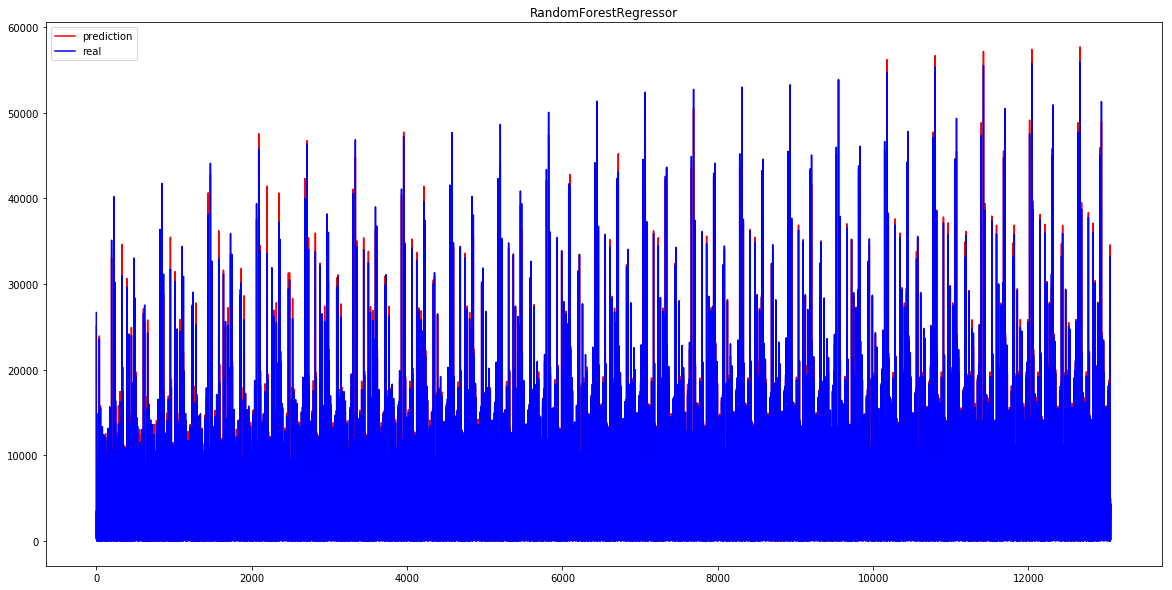

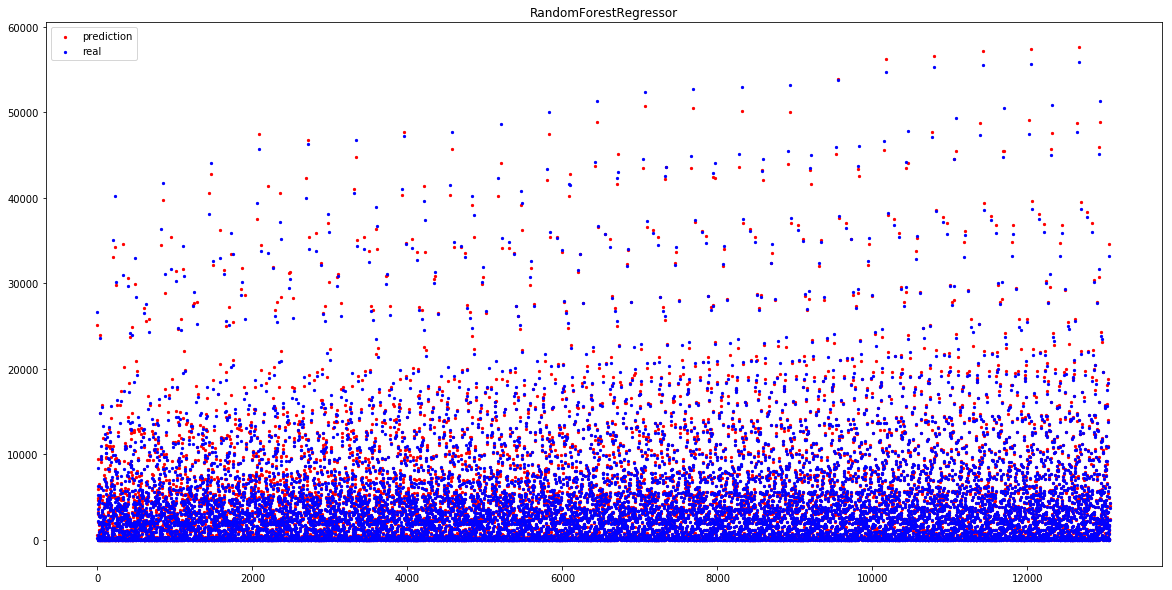

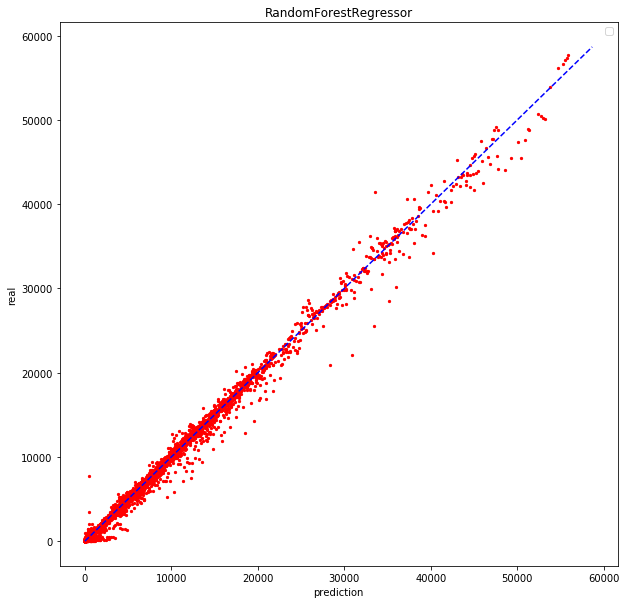

In [43]:
plt.figure(figsize=(20,10))
plt.plot(pred, 'r', label='prediction')
plt.plot(y_test, 'b', label='real')
plt.title("RandomForestRegressor")
plt.legend(loc='best')
plt.savefig("./figure/RandomF/plt_rf4.eps")
plt.figure(figsize=(20,10))
plt.scatter([i+1 for i in range(y_test.shape[0])],pred, color='r', label='prediction',s=5)
plt.scatter([i+1 for i in range(y_test.shape[0])],y_test, color='b', label='real',s=5)
plt.title("RandomForestRegressor")
plt.legend(loc='best')
plt.savefig("./figure/RandomF/scatter_rf4.eps")
plt.figure(figsize=(10,10))
plt.scatter(y_test,pred, color='r',s=5)
plt.plot([0,np.max([np.max(y_test),np.max(pred)])+1000],[0,np.max([np.max(y_test),np.max(pred)])+1000],"b",ls='--')
plt.title("RandomForestRegressor")
plt.ylabel("real")
plt.xlabel("prediction")
plt.legend(loc='best')
plt.savefig("./figure/RandomF/pt_rf4.eps")